In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib.mlab import PCA

import FindPeaks
import syntheticspectra
import PCAsynthetic

%matplotlib inline

In [3]:
spectralmatrix = syntheticspectra.spectralmatrix

#### 1. Calculate an average spectrum to ID peaks

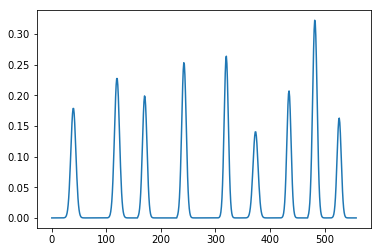

In [14]:
averagespectrum = PCAsynthetic.get_hyper_peaks(spectralmatrix, threshold = 0.01)

plt.plot(averagespectrum)

#### 2. Make a feature matrix, n x p, where n = number of samples, p = number of features

In [20]:
featurematrix = PCAsynthetic.makefeaturematrix(spectralmatrix, averagespectrum)
featurematrix[10:13,:]

array([[ 0.23316946,  0.23316946,  0.        ,  0.33072845,  0.27053844,
         0.        ,  0.27053844,  0.33072845,  0.        ],
       [ 0.24731764,  0.24731764,  0.        ,  0.35079628,  0.28695409,
         0.        ,  0.28695409,  0.35079628,  0.        ],
       [ 0.25908402,  0.25908402,  0.        ,  0.36748576,  0.30060621,
         0.        ,  0.30060621,  0.36748576,  0.        ]])

#### 3. Standardize: zero mean, unit variance. (and check!) 

In [27]:
featurematrix_std = PCAsynthetic.stdfeature(featurematrix, axis = 0)
#along axis 0  = running vertically downwards, across rows; 1 = columns
mean = featurematrix_std.mean(axis=0)
variance = featurematrix_std.std(axis=0)
print(mean, variance)

(array([ -3.31221151e-13,  -5.64543563e-14,  -3.05146601e-14,
         5.56527050e-13,  -5.01340099e-14,   4.17187111e-13,
         1.36717027e-13,  -1.18744024e-14,  -2.08835770e-14]), array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


#### 4. Sklearn PCA 

In [61]:
#define number of principal components 
sklearn_pca = sklearnPCA(n_components=9)

#matrix with each sample in terms of the PCs
SkPC = sklearn_pca.fit_transform(featurematrix_std)

#covariance matrix 
Skcov = sklearn_pca.get_covariance()

#score matrix 
#Skscore = sklearn_pca.score_samples(featurematrix_std)

#explained variance
Skvariance = sklearn_pca.explained_variance_
Skvarianceratio = sklearn_pca.explained_variance_ratio_

In [65]:
Skvarianceratio


array([  4.34213151e-01,   3.33333333e-01,   2.32453516e-01,
         6.90452850e-29,   1.82242697e-29,   9.73401994e-32,
         4.06605824e-32,   1.86902077e-33,   1.59108785e-33])

In [66]:
Skvariance

array([  3.90791836e+00,   3.00000000e+00,   2.09208164e+00,
         6.21407565e-28,   1.64018428e-28,   8.76061795e-31,
         3.65945241e-31,   1.68211869e-32,   1.43197906e-32])

##### 5. Matrix decomposition (see A User's Guide to Principal Components by Jackson, 1991.)


U’SU  = L 

U = orthonormal matrix, characteristic vectors  
S = covariance matrix  
L = diagonal matrix, characteristic roots  


Get characteristic roots: |𝑺−𝒍𝑰|=𝟎  
Get characteristic vector: |𝑺−𝒍𝑰|𝒕𝒊=𝟎  
The projection of sample n onto principal component i: z$_i$ = u$^{’}_{i}$[x$_{n}$-x$_{avg}$]


In [40]:
mean_vec = np.mean(featurematrix_std, axis=0)

#need to take transpose, since rowvar = true by default
cov_mat = np.cov(featurematrix_std.T)

#solve for characteristic roots and vectors 
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [67]:
#check that the loadings squared sum to 1: 
Lsquared = sum(eig_vecs**2)

#### 6. Matlab's PCA

In [69]:
mlPCA = PCA(featurematrix_std)
#get projections of samples into PCA space
mltrans = mlPCA.Y
#reshape
mltransreshape = mltrans.reshape((256,256,9))
mlloadings = mlPCA.Wt
#mltrans[513,:] should be the same as mltransreshape[2,1,:]
mlloadings.shape

(9, 9)

#### Check that all three give similar results

In [72]:
#projection of first sample, on to the first PC 
P11 = np.dot(eig_vecs[:,0], featurematrix_std[0,:]-mean_vec) 
mlP11 = mlPCA.Y[0,0]
SkP11 = SkPC[0,0]

P12 = np.dot(eig_vecs[:,1], featurematrix_std[0,:]-mean_vec) 
mlP12 = mlPCA.Y[0,1]
SkP12 = SkPC[0,1]

P152 = np.dot(eig_vecs[:,1], featurematrix_std[15,:]-mean_vec) 
mlP152 = mlPCA.Y[15,1]
SkP152 = SkPC[15,1]

print(P11, mlP11, SkP11)
print(P12, mlP12, SkP12)
print(P152, mlP152, SkP152)

(-4.6919013149594857, -4.6919013149588888, -4.6919013149637498)
(-0.86246021536739081, 0.86246021536795736, 0.86246021537224582)
(3.1504839305569994, -3.1504839305569039, -3.1504839305570069)


In [81]:
print(mlloadings[0,7])
print(eig_vecs[0,7])

0.408248290464
0.0907047668042


### PCA with the entire IR spectrum. 

In [111]:
#Reshape spectral matrix 
IRmatrix=spectralmatrix.reshape(65536,559)
print(IRmatrix[1,:].shape)

(559,)


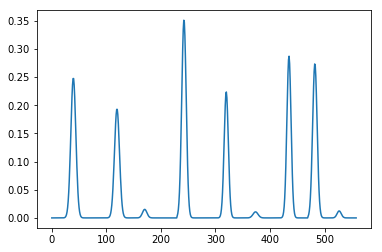

In [112]:
#make sure we've reshaped correctly 
plt.plot(reshapespect[555,:])

#### Standardize matrix 

In [115]:
IRmatrix=np.concatenate((IRmatrix[:,20:60], IRmatrix[:,230:270], IRmatrix[:,420:460], IRmatrix[:,100:140],IRmatrix[:,305:345], IRmatrix[:,470:510], IRmatrix[:,158:198], IRmatrix[:,354:394], IRmatrix[:,512:552] ), axis=1)
#IRmatrix=np.concatenate((IRmatrix[:,30:40], IRmatrix[:,240:260], IRmatrix[:,430:450], IRmatrix[:,90:130],IRmatrix[:,395:335], IRmatrix[:,460:500], IRmatrix[:,148:188], IRmatrix[:,364:384], IRmatrix[:,522:542] ), axis=1)


In [116]:
IRmatrix_std = PCAsynthetic.stdfeature(IRmatrix, axis = 0)
IRmean = IRmatrix_std.mean(axis=0)
IRvariance = IRmatrix_std.std(axis=0)
print(IRvariance)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [117]:
IRmlPCA = PCA(IRmatrix_std)
#get projections of samples into PCA space
IRmltrans = IRmlPCA.Y
#reshape
IRmlloadings = IRmlPCA.Wt
IRmltrans.shape

(65536, 360)

In [118]:
IRmltransreshape=IRmltrans.reshape(256,256,360)

In [126]:
score1image = IRmltransreshape[:,:,0]
score2image = IRmltransreshape[:,:,1]
score3image = IRmltransreshape[:,:,2]
score4image = IRmltransreshape[:,:,3]
score5image = IRmltransreshape[:,:,4]
score6image = IRmltransreshape[:,:,5]
score7image = IRmltransreshape[:,:,6]
score8image = IRmltransreshape[:,:,7]
score9image = IRmltransreshape[:,:,8]

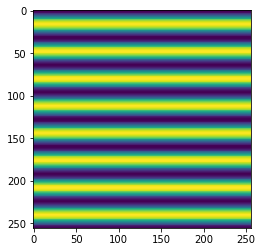

In [4]:
plt.imshow(syntheticspectra.Cmatrix)

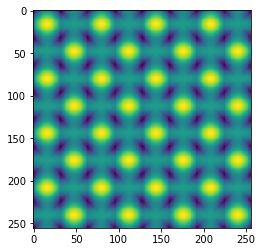

In [120]:
plt.imshow(score1image)

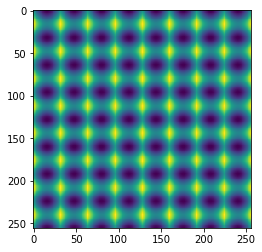

In [121]:
plt.imshow(score2image)

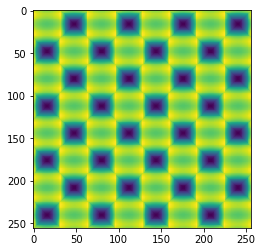

In [122]:
plt.imshow(score3image)

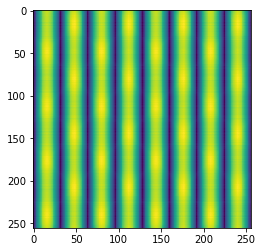

In [124]:
plt.imshow(score4image)

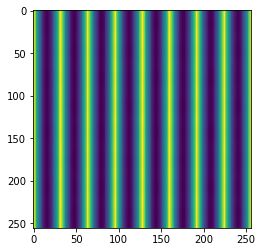

In [125]:
plt.imshow(score5image)

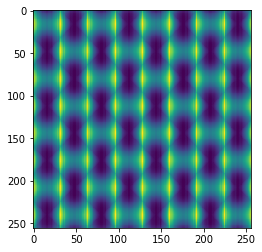

In [127]:
plt.imshow(score6image)

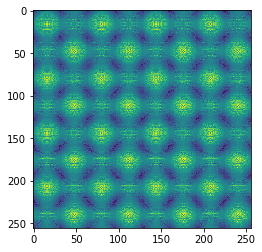

In [128]:
plt.imshow(score7image)

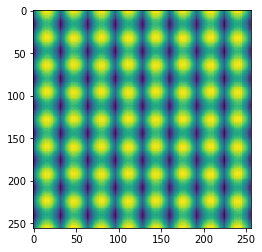

In [129]:
plt.imshow(score8image)

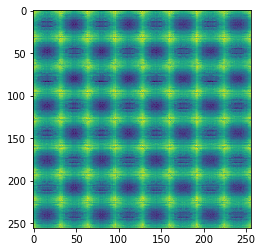

In [130]:
plt.imshow(score9image)